We will show how to predict the DMD (and its variants) solution using the Koopman operator

In [1]:
import numpy as np
import scipy.sparse as sp
from mpl_toolkits import mplot3d
from rom_am import ROM, DMD, KERDMD
import matplotlib.pyplot as plt
import scipy.interpolate as si
from scipy.integrate import solve_ivp

We are learning here the system:
$$
\dot x_1 = \mu x_1\\
\dot x_2 = \lambda (x_2 - x_1^2)\\
$$
With $\mu = -0.03$, $\lambda = -0.35$ and $\begin{pmatrix} x_1 \\ x_2 \end{pmatrix}_0 = \begin{pmatrix} 2 \\ -1 \end{pmatrix}$

The system can be transformed to a basis where the dynamics are linear :

$$\begin{pmatrix} y_1 \\ y_2 \\ y_3 \end{pmatrix} = \begin{pmatrix} x_1 \\ x_2 \\ x_1^2 \end{pmatrix}$$

In [2]:
## ======================= Creating the HF Data ==============================
def create_data():
    lambdd = -0.35
    mu = -0.03
    oper = np.array([[mu, 0., 0.], [0., lambdd, -lambdd], [0., 0, 2*mu]])
    dt = 0.06
    input_t = np.arange(0, 290, dt)
    init_data = np.array([2, -1])
    nonlinobs_init = np.array([init_data[0], init_data[1], init_data[0]**2])
    
    def f(t, y): return oper @ y
    sol = solve_ivp(f, [0, input_t[-1]], nonlinobs_init, t_eval = input_t)
    input_data = sol.y.copy()
    
    return input_data, input_t, dt

input_data, input_t, dt = create_data()

In [3]:
## ======================= DMD Learning and predicting ==============================
X = input_data[:, :-1]
Y = input_data[:, 1::]

dmd = DMD()
drom = ROM(dmd)
drom.decompose(X,  Y = Y, dt = dt)
pred = drom.predict(t=input_t)

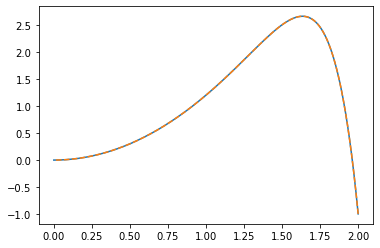

In [4]:
plt.plot(X[0, :], X[1, :]);
plt.plot(pred[0, :-1], pred[1, :-1], '--');

In [5]:
## =============== Prediction using Koopman =====================
koop_pred = np.empty(pred.shape)
koop_pred[:, 0] = X[:, 0]

phi0 = dmd.koop_eigf(koop_pred[:, 0][:, np.newaxis])

for i in range(len(input_t)-1):
    koop_pred[:, i+1] = (dmd.dmd_modes @ (np.diag(dmd.koop_eigv)**(i+1)) @ (phi0)).ravel()

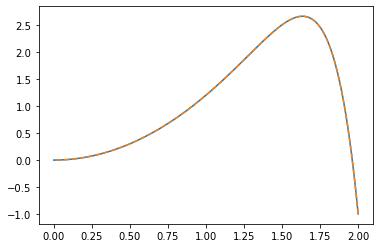

In [6]:
plt.plot(X[0, :], X[1, :]);
plt.plot(koop_pred[0, :-1], koop_pred[1, :-1], '--');

We ue now Kernel DMD with data including only $x_1$ and $x_2$, and leveraging a poynomial kernel of the 2nd degree

In [7]:
## ======================= KerDMD Learning and predicting ==============================
X = input_data[:2, :-1]
Y = input_data[:2, 1::]

kdmd = KERDMD()
kdrom = ROM(kdmd)
kdrom.decompose(X,  Y = Y, dt = dt, kernel = "poly", p=2)

In [8]:
## =============== Prediction using Koopman =====================
koop_pred = np.empty((2, len(input_t)))
koop_pred[:, 0] = X[:, 0]
phi0 = kdmd.koop_eigf(koop_pred[:, 0][:, np.newaxis])

for i in range(len(input_t)-1):
    koop_pred[:, i+1] = (kdmd.dmd_modes @ (np.diag(kdmd.koop_eigv)**(i+1)) @ (phi0)).ravel()

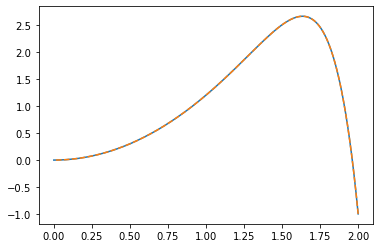

In [9]:
plt.plot(X[0, :], X[1, :]);
plt.plot(koop_pred[0, :-1], koop_pred[1, :-1], '--');